In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.nn.init as init
import time
import random
import pandas as pd
import openpyxl
from matplotlib.axis import Axis
import cv2

In [5]:
def min_max(x_min, x_max, y_min, y_max):
    X = []
    Y = []
    LF = []
    fig, ax = plt.subplots(figsize=(6,5))

    X.append(x_min)
    X.append(x_max)
    X.append(x_min)
    X.append(x_max)

    Y.append(y_min)
    Y.append(y_max)
    Y.append(y_max)
    Y.append(y_min)

    LF.append(1)
    LF.append(1)
    LF.append(1)
    LF.append(1)

    sc = plt.scatter(X, Y, c=LF, cmap='Greys')
    plt.tick_params(direction='in', width=0.5, length = 0.5, labelsize=17)
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(1))
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(1))
    for spine in plt.gca().spines.values():
        spine.set_linewidth(1.2)
    plt.clim(0, 1)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    figname = 'tp.tiff'
    plt.savefig(figname, format='tiff', bbox_inches='tight')
    
    plt.close()

    # Load the black and white image
    image_path = 'tp.tiff'  # Replace with the path to your black and white image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read the image as grayscale
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    X_cv = []
    Y_cv = []
    for contour in contours:
        for point in contour:
            x, y = point[0]
            y = image.shape[0] - y - 1
            X_cv.append(x)
            Y_cv.append(y)
#             print(f'Point: ({x}, {y})')
    return min(X_cv), max(X_cv), min(Y_cv), max(Y_cv)       

def interface(X,Y,LF,x_min, x_max, y_min, y_max):
    fig, ax = plt.subplots(figsize=(6,5))
    sc = plt.scatter(X, Y, c=LF, cmap='Greys')
    plt.tick_params(direction='in', width=0.5, length = 0.5, labelsize=17)
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(1))
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(1))
    for spine in plt.gca().spines.values():
        spine.set_linewidth(1.2)
    plt.clim(0, 1)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    figname = 'LF.tiff'
    plt.savefig(figname, format='tiff', bbox_inches='tight')
    plt.close()
    
    # Load the black and white image
    image_path = 'LF.tiff'  # Replace with the path to your black and white image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read the image as grayscale
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    X_int = []
    Y_int = []
    for contour in contours:
        for point in contour:
            x, y = point[0]
            y = image.shape[0] - y - 1
            X_int.append(x)
            Y_int.append(y)
            
    return X_int, Y_int

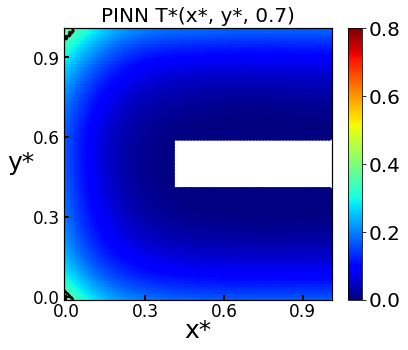

In [21]:
time = 0.7
sides = 3
x_min = -0.01
x_max = 1.01
y_min = -0.01
y_max = 1.01
c_max = 0.8

x_min_cv, x_max_cv, y_min_cv, y_max_cv = min_max(x_min, x_max, y_min, y_max)

file_path = 'error_'+str(sides)+'sidE.xlsx'
sheet_name = 't = ' + str(time)
DF = pd.read_excel(file_path, sheet_name=sheet_name)
X = DF['X'].values
Y = DF['Y'].values
CFD = DF['CFD'].values
PINN = DF['PINN'].values
error = DF['error'].values

######### PINN ###########

LF = PINN>0.35

X_int_cv, Y_int_cv = interface(X,Y,LF,x_min, x_max, y_min, y_max)

X_int = [(x_max - x_min) / (x_max_cv - x_min_cv) * (value - x_min_cv) + x_min for value in X_int_cv]
Y_int = [(y_max - y_min) / (y_max_cv - y_min_cv) * (value - y_min_cv) + y_min for value in Y_int_cv]

start = 0
end = -2

fig, ax = plt.subplots(figsize=(6,5))
sc = plt.scatter(X, Y, c=PINN, cmap=plt.cm.jet)
plt.plot(X_int[start:end], Y_int[start:end], color = 'black', linewidth = 2.5)
plt.tick_params(direction='in', width=2, length = 5, labelsize=17)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(4))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(4))
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.2)
plt.clim(0, c_max)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=20)
plt.xlabel('x*',fontsize=25,fontdict={'family': 'Helvetica'}, labelpad=1, ha='right', va='top')
Axis.set_label_coords(ax.xaxis, 0.55, -0.07) 
plt.ylabel('y*',fontsize=25,fontdict={'family': 'Helvetica'}, rotation = 360, labelpad=1, ha='right', va='top')
Axis.set_label_coords(ax.yaxis, -0.11, 0.55) 
tit = 'PINN T*(x*, y*, '+str(time)+')'
plt.title(tit,fontsize=20,fontdict={'family': 'Helvetica'})

figname = 'PINN_'+str(sides)+'side'+'_temperaturecontour_t='+str(time)+'.tiff'
plt.savefig(figname, format='tiff', bbox_inches='tight')

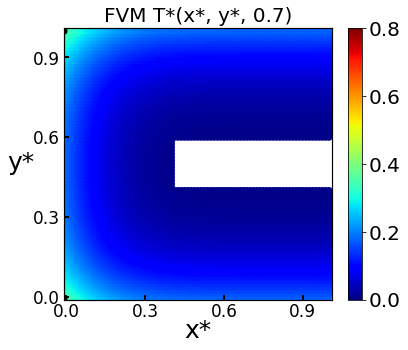

In [22]:
############## FVM ##############

LF = CFD>0.35

X_int_cv, Y_int_cv = interface(X,Y,LF,x_min, x_max, y_min, y_max)

X_int = []
Y_int = []
X_int = [(x_max - x_min) / (x_max_cv - x_min_cv) * (value - x_min_cv) + x_min for value in X_int_cv]
Y_int = [(y_max - y_min) / (y_max_cv - y_min_cv) * (value - y_min_cv) + y_min for value in Y_int_cv]

start = 0
end = -2

fig, ax = plt.subplots(figsize=(6,5))
sc = plt.scatter(X, Y, c=CFD, cmap=plt.cm.jet)
plt.plot(X_int[start:end], Y_int[start:end], color = 'black', linewidth = 2.5)
plt.tick_params(direction='in', width=2, length = 5, labelsize=17)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(4))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(4))
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.2)
plt.clim(0, c_max)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=20)
plt.xlabel('x*',fontsize=25,fontdict={'family': 'Helvetica'}, labelpad=1, ha='right', va='top')
Axis.set_label_coords(ax.xaxis, 0.55, -0.07) 
plt.ylabel('y*',fontsize=25,fontdict={'family': 'Helvetica'}, rotation = 360, labelpad=1, ha='right', va='top')
Axis.set_label_coords(ax.yaxis, -0.11, 0.55) 
tit = 'FVM T*(x*, y*, '+str(time)+')'
plt.title(tit,fontsize=20,fontdict={'family': 'Helvetica'})

figname = 'FVM_'+str(sides)+'side'+'_temperaturecontour_t='+str(time)+'.tiff'
plt.savefig(figname, format='tiff', bbox_inches='tight')

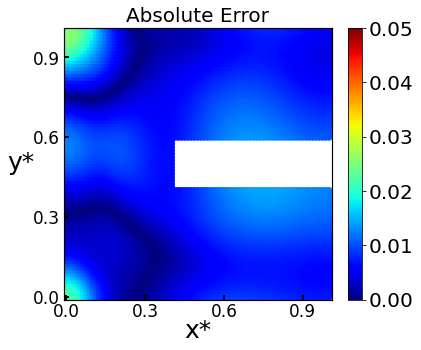

In [23]:
file_path = 'error_'+str(sides)+'side.xlsx'
sheet_name = 't = ' + str(time)
DF = pd.read_excel(file_path, sheet_name=sheet_name)
X = DF['X'].values
Y = DF['Y'].values
CFD = DF['CFD'].values
PINN = DF['PINN'].values
error = DF['error'].values

fig, ax = plt.subplots(figsize=(6,5))
sc = plt.scatter(X, Y, c=error, cmap=plt.cm.jet)
plt.tick_params(direction='in', width=2, length = 5, labelsize=17)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(4))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(4))
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.2)
plt.clim(0, 0.05)
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=20)
cbar.ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
plt.xlabel('x*',fontsize=25,fontdict={'family': 'Helvetica'}, labelpad=1, ha='right', va='top')
Axis.set_label_coords(ax.xaxis, 0.55, -0.07) 
plt.ylabel('y*',fontsize=25,fontdict={'family': 'Helvetica'}, rotation = 360, labelpad=1, ha='right', va='top')
Axis.set_label_coords(ax.yaxis, -0.11, 0.55) 
tit = 'Absolute Error'
plt.title(tit,fontsize=20,fontdict={'family': 'Helvetica'})

figname = 'error_'+str(sides)+'side'+'_temperaturecontour_t='+str(time)+'.tiff'
plt.savefig(figname, format='tiff', bbox_inches='tight')

Text(0.5, 1.0, 'x* = y* , t* = 2.1')

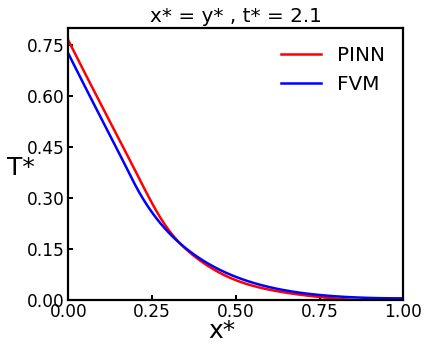

In [11]:
sides = 2
time = 2.1

file_path = str(sides)+'side_y=x_fulldomain.xlsx'
DF = pd.read_excel(file_path, sheet_name='y = 0.2, t = '+str(time) )
X = DF['X'].values
PINN = DF['T_pinn'].values
FVM = DF['T_fvm'].values

fig, ax = plt.subplots(figsize=(6,5))
plt.plot(X, PINN, color = 'red', linewidth = 2.5, label = 'PINN')
plt.plot(X, FVM, color = 'blue', linewidth = 2.5, label = 'FVM')
plt.tick_params(direction='in', width=2, length = 5, labelsize=17)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(6))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(4))
for spine in plt.gca().spines.values():
    spine.set_linewidth(2.2)
plt.xlim(0, 1)
plt.ylim(0, 0.8)
plt.legend(fontsize=20, frameon=False)
plt.xlabel('x*',fontsize=25,fontdict={'family': 'Helvetica'}, labelpad=1, ha='right', va='top')
Axis.set_label_coords(ax.xaxis, 0.5, -0.07) 
plt.ylabel('T*',fontsize=25,fontdict={'family': 'Helvetica'}, rotation = 360, labelpad=1, ha='right', va='top')
Axis.set_label_coords(ax.yaxis, -0.1, 0.53) 
tit = 'x* = y* , t* = '+str(time)
plt.title(tit,fontsize=20,fontdict={'family': 'Helvetica'})

# figname = str(sides)+'side_x=y_t='+str(time)+'.tiff'
# plt.savefig(figname, format='tiff', bbox_inches='tight')